In [2]:
import pyaudio #handling recording function
import wave #handling .wav file
import numpy as np
import matplotlib.pyplot as plt
import time
from cmath import exp, pi

%matplotlib inline

class Recorder:
    def __init__(self):
        # recording time (unit:s)
        self.record_time = 3
        # file name
        self.output_wavfile = "record.wav"
        # index number of microphone
        self.idevice = 1
        # format of audio
        self.format = pyaudio.paInt16
        # monaural
        self.nchannels = 1
        # sampling rate,which is usually 16KHz(=16kHz?)
        self.sampling_rate = 8192*2
        # number of extracted data at a time,that is called chunk
        self.chunk = 2**10
        # get device information
        self.audio = pyaudio.PyAudio()
    
    def __exit__(self):
        self.close()
        
    def set_config(self):
        # foundimental information
        # format of audio
        self.format = pyaudio.paInt16
        # monaural
        self.nchannels = 1
        # sampling rate,which is usually 16kHz
        self.sampling_rate = 8192*2
        # number of extracted data at a time,that is called chunk
        self.chunk = 2**10
        
    def show_deviceinfo(self):
        for i in range(self.audio.get_device_count()):
            print(self.audio.get_device_info_by_index(i))

    def record(self, wfile_list=["record.wav"]):
        for w in wfile_list:
            stream = self.audio.open(
            format = self.format,
            channels = self.nchannels,
            rate = self.sampling_rate,
            input = True,
            input_device_index = self.idevice, # device1(Mouse_mic) will be used for input device
            frames_per_buffer = self.chunk)

            print ("start recording...")
            frames = []
            for i in range(0, int(self.sampling_rate / self.chunk * self.record_time)):
                data = stream.read(self.chunk) # chunkごとにdataを書き出す write raw data at each chunk
                frames.append(data)
            print ("finished recording\n")
            return self.prepare_file(frames, w)
                    
    def prepare_file(self, frames, wfile, mode='wb'):
        if wfile != self.output_wavfile:
            self.output_wavfile = wfile
        wavefile = wave.open(wfile, mode)
        wavefile.setnchannels(self.nchannels)
        wavefile.setsampwidth(self.audio.get_sample_size(self.format))
        wavefile.setframerate(self.sampling_rate)
        wavefile.writeframes(b"".join(frames))
        return self.output_wavfile
        
    def close(self):
        stream.close()
        self.audio.terminate()
        self.output_wavfile.close()
#end of class Record

In [5]:
# recording test
n = 3
#wavlist = ["record"+str(i)+".wav" for i in range(n)]

record = Recorder()
#record.show_deviceinfo()
record.record()

start recording...
finished recording



'record.wav'

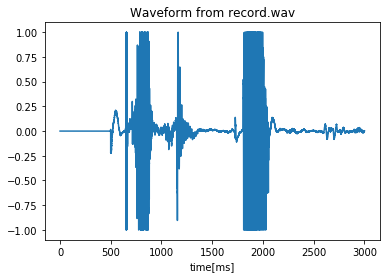

In [6]:
spf = wave.open("./record.wav", "rb")
fs = spf.getframerate()
# extract raw data from wavfile
signal = spf.readframes(-1) # read all data
signal = np.frombuffer(signal, dtype="int16") / float(2**15) # normalize
time = np.linspace(0, len(signal)/fs, num=len(signal))

plt.title("Waveform from record.wav")
plt.xlabel("time[ms]")
plt.plot(1000*time, signal)
plt.show()

In [8]:
#from scipy.fftpack import fft, rfft
def _fft(x):
    N = len(x)
    if N <= 1: return x
    even = _fft(x[0::2])
    odd  = _fft(x[1::2])
    T = [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

# zero padding
dataSz = len(signal)
zeros = np.zeros(2**int(np.log2(dataSz)+1)-dataSz)
print("zeros=", len(zeros))
print("audio shape=", signal.shape)
#fft_list = np.resize(signal, 2**int(np.log2(dataSz))) #1024*131072

nfft = 2**int(np.log2(dataSz)+1)
spec = np.abs(np.fft.fft(signal, nfft)/(nfft/2)) #np.fft.fft(signal, nffft) nfftで2^Nとしてデータ数を渡す
fscale = np.fft.fftfreq(nfft, d = 1.0/fs)
print(spec.shape, fscale.shape)

zeros= 16384
audio shape= (49152,)
(65536,) (65536,)


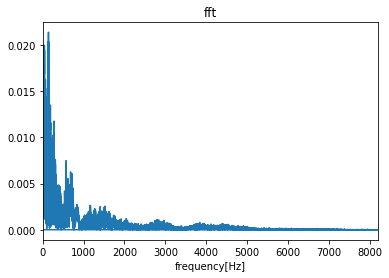

In [9]:
plt.title("fft")
#plt.plot(fscale, spec, label="fft")
plt.plot(fscale, spec, label="fft")
plt.xlabel("frequency[Hz]")
plt.xlim(0, fs//2)
plt.show()

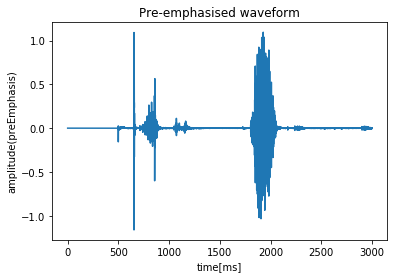

In [10]:
import scipy.signal

#プリエンファシスフィルタ
def preEmphasis(signal, p):
    #signal = voice_signal, p = coefficient
    #make FIR filter such that coefficients are (1.0, p)
    return scipy.signal.lfilter([1.0, -p], 1, signal)

# multiply preEmphasis filter
p = 0.97
signal = preEmphasis(signal, p)
time = np.linspace(0, len(signal)/fs, num=len(signal))

plt.title("Pre-emphasised waveform")
plt.xlabel("time[ms]")
plt.ylabel("amplitude(preEmphasis)")
plt.plot(1000*time, signal)
plt.show()

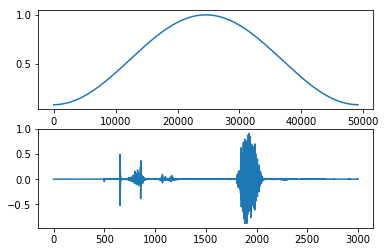

In [11]:
# hamming windowをかける
hammingWindow = np.hamming(len(signal))
signal = signal * hammingWindow

plt.subplot(211)
plt.plot(hammingWindow)
plt.subplot(212)
plt.plot(time*1000, signal)
plt.show()

16384 (131072,)


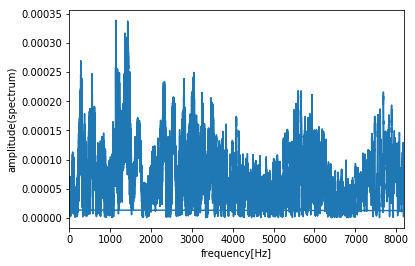

In [12]:
# get spectrum
nfft = 2**18
spec = np.abs(np.fft.fft(signal, nfft)/(nfft/2))[:nfft//2] #np.fft.fft(signal, nffft) nfftで2^Nとしてデータ数を渡す
fscale = np.fft.fftfreq(nfft//2, d = 1.0/fs)[:nfft//2]
print(fs, spec.shape)

plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude(spectrum)")
plt.xlim(0, fs//2)
plt.plot(fscale, spec)
plt.show()

In [13]:
def hz2mel(f):
    return 1127.01048 * np.log(f/700.0 + 1.0)

def mel2hz(m):
    return 700*(np.exp(m/1127.01048) - 1.0)

In [14]:
def melFilterBank(fs, nfft, nchannels):
    #ナイキスト周波数
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = nfft // 2
    df = fs / nfft
    dmel = melmax / (nchannels + 1)
    melcenters = np.arange(1, nchannels + 1) * dmel
    fcenter = mel2hz(melcenters)
    indexcenter = np.round(fcenter / df)
    indexstart = np.hstack((0, indexcenter[0:nchannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:nchannels], [nmax]))
    
    filterbank = np.zeros((nchannels, nmax))
    
    for c in np.arange(0, nchannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            filterbank[c, int(i)] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            filterbank[c, int(i)] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenter

numChannels = 24
df = fs / nfft
filterbank, fcenters = melFilterBank(fs, nfft, numChannels)
print(filterbank.shape)
#for c in np.arange(0, numChannels):
#    plot(np.arange(0, nfft / 2) * df, filterbank[c])

(24, 131072)


In [15]:
# 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、
# 振幅の和の対数をとる
mspec = []
for c in np.arange(0, numChannels):
    mspec.append(np.log10(sum(spec * filterbank[c])))
mspec = np.array(mspec)

In [16]:
from scipy.fftpack import realtransforms

def get_mfcc(mspec, nceps):
    #離散コサイン変換 DCT
    ceps = realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    #低次の成分からnceps個の係数を返す
    return ceps[:nceps]

mfcc = get_mfcc(mspec, 12)
print(type(mfcc))
mfcc

<class 'numpy.ndarray'>


array([-2.97490176, -0.61512386, -0.5644097 ,  0.08889806, -0.4601871 ,
        0.22681145, -0.19952994, -0.03148783,  0.08879237,  0.04159362,
       -0.06195896, -0.24869992])

In [13]:
#import pyaudio #handling recording function
import wave #handling .wav file
import numpy as np
#import matplotlib.pyplot as plt
import scipy.signal
from scipy.fftpack import realtransforms
import pandas as pd

#プリエンファシスフィルタ
def preEmphasis(signal, p):
    #signal = voice_signal, p = coefficient
    #make FIR filter such that coefficients are (1.0, p)
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def hz2mel(f):
    return 1127.01048 * np.log(f/700.0 + 1.0)

def mel2hz(m):
    return 700*(np.exp(m/1127.01048) - 1.0)

def melFilterBank(fs, nfft, nchannels):
    #ナイキスト周波数
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = nfft // 2
    df = fs / nfft
    dmel = melmax / (nchannels + 1)
    melcenters = np.arange(1, nchannels + 1) * dmel
    fcenter = mel2hz(melcenters)
    indexcenter = np.round(fcenter / df)
    indexstart = np.hstack((0, indexcenter[0:nchannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:nchannels], [nmax]))
    
    filterbank = np.zeros((nchannels, nmax))
    
    for c in np.arange(0, nchannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            filterbank[c, int(i)] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            filterbank[c, int(i)] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenter

def get_mfcc(mspec, nceps):
    #離散コサイン変換 DCT
    ceps = realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    #低次の成分からnceps個の係数を返す
    return ceps[:nceps]

##########################################################################################################################
move_fSz=40
move_bSz=40
dataSetSz = move_fSz + move_bSz

test_data = pd.DataFrame()

for t in range(dataSetSz):
    spf = wave.open("./sample/record{}.wav".format(t), "rb")
    fs = spf.getframerate()
    # extract raw data from wavfile
    signal = []
    signal = spf.readframes(-1) #read all data
    signal = np.frombuffer(signal, dtype="int16") / float(2**15) #normalize

    # multiply preEmphasis filter
    p = 0.97
    signal = preEmphasis(signal, p)

    # hamming windowをかける
    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow

    # get spectrum
    dataSz = len(signal)
    nfft = 2**int(np.log2(dataSz)+1)
    spec = np.abs(np.fft.fft(signal, nfft)/(nfft/2))[:nfft//2]

    numChannels = 24
    df = fs / nfft
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)

    # 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、
    # 振幅の和の対数をとる
    mspec = []
    for c in np.arange(0, numChannels):
        mspec.append(np.log10(sum(spec * filterbank[c])))
    mspec = np.array(mspec)

    mfcc = get_mfcc(mspec, 12)
    #print(type(mfcc), mfcc)
    mfcc_df = pd.DataFrame(mfcc).T
    if t < move_fSz:
        mfcc_df["target"] = 0 # 0 means move_forward
    else:
        mfcc_df["target"] = 1 # 1 means move_backward
    
    test_data = test_data.append(mfcc_df)

            0         1         2         3         4         5         6  \
0   -3.108858 -0.691792 -0.234556  0.015411 -0.347766  0.178876 -0.133475   
0   -2.128857 -1.042360 -0.439860 -0.103412 -0.358317  0.125987 -0.077745   
0   -2.759297 -0.940817 -0.257120 -0.095869 -0.298068  0.146854 -0.171971   
0   -2.901618 -0.607908 -0.351994 -0.041318 -0.297541  0.194192 -0.219863   
0   -2.168932 -1.064203 -0.369191 -0.183285 -0.334636  0.047652 -0.136492   
0   -2.797547 -0.558252 -0.521756 -0.041294 -0.212443 -0.020184 -0.083844   
0   -3.235084 -0.685291 -0.058211 -0.028202 -0.216203  0.122967 -0.125534   
0   -2.500043 -0.869477 -0.365821 -0.138462 -0.218400  0.068434 -0.112604   
0   -2.374481 -0.912227 -0.359212 -0.187869 -0.259452  0.040652 -0.079125   
0   -2.215797 -0.860634 -0.466267 -0.131177 -0.325468  0.007192 -0.139843   
0  -11.028180 -0.912636  0.682371  0.551145  0.422479  0.446576  0.251036   
0   -2.267810 -0.875926 -0.487970 -0.226363 -0.221676 -0.035650 -0.071691   

In [16]:
dataSet = test_data.reset_index(drop=True)
dataSet

,0,1,2,3,4,5,6,7,8,9,10,11,target
0,-3.108858,-0.691792,-0.234556,0.015411,-0.347766,0.178876,-0.133475,0.162430,0.068556,0.134832,-0.063844,0.001222,0
1,-2.128857,-1.042360,-0.439860,-0.103412,-0.358317,0.125987,-0.077745,0.346825,0.084838,0.186447,-0.036676,-0.210077,0
2,-2.759297,-0.940817,-0.257120,-0.095869,-0.298068,0.146854,-0.171971,0.207872,0.134361,0.155747,-0.074939,-0.112170,0
3,-2.901618,-0.607908,-0.351994,-0.041318,-0.297541,0.194192,-0.219863,0.183741,0.072224,0.137748,0.004564,-0.030446,0
4,-2.168932,-1.064203,-0.369191,-0.183285,-0.334636,0.047652,-0.136492,0.235908,0.187304,0.185850,0.026407,-0.158787,0
5,-2.797547,-0.558252,-0.521756,-0.041294,-0.212443,-0.020184,-0.083844,0.133934,0.078464,0.173504,-0.037450,-0.071707,0
6,-3.235084,-0.685291,-0.058211,-0.028202,-0.216203,0.122967,-0.125534,0.196965,0.040365,0.199745,0.036683,-0.049383,0
7,-2.500043,-0.869477,-0.365821,-0.138462,-0.218400,0.068434,-0.112604,0.297517,0.172715,0.176689,0.006779,-0.126761,0
8,-2.374481,-0.912227,-0.359212,-0.187869,-0.259452,0.040652,-0.079125,0.353058,0.180505,0.188890,0.087804,-0.098810,0
9,-2.215797,-0.860634,-0.466267,-0.131177,-0.325468,0.007192,-0.139843,0.241289,0.214525,0.155422,-0.026355,-0.157402,0


In [17]:
test_data.to_csv("./audioDataSet.csv")

In [2]:
import pandas as pd
test_df = pd.read_csv("./audioDataSet.csv", index_col=0).reset_index(drop=True)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,target
0,-3.108858,-0.691792,-0.234556,0.015411,-0.347766,0.178876,-0.133475,0.162430,0.068556,0.134832,-0.063844,0.001222,0
1,-2.128857,-1.042360,-0.439860,-0.103412,-0.358317,0.125987,-0.077745,0.346825,0.084838,0.186447,-0.036676,-0.210077,0
2,-2.759297,-0.940817,-0.257120,-0.095869,-0.298068,0.146854,-0.171971,0.207872,0.134361,0.155747,-0.074939,-0.112170,0
3,-2.901618,-0.607908,-0.351994,-0.041318,-0.297541,0.194192,-0.219863,0.183741,0.072224,0.137748,0.004564,-0.030446,0
4,-2.168932,-1.064203,-0.369191,-0.183285,-0.334636,0.047652,-0.136492,0.235908,0.187304,0.185850,0.026407,-0.158787,0


In [3]:
from sklearn.model_selection import train_test_split
#targetの列をdropする
X = test_df.drop("target", axis=1)
Y = test_df["target"]

#ここから学習用データとテスト用のデータに分ける。random_stateは乱数を固定する
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# k-NN instance, in this time we choose 5-neighbors
model = KNeighborsClassifier(n_neighbors=5)
# construct a model...takes train_data and train_label
model.fit(X_train, Y_train)

#### accuracy 97 percent!! ###
print("train score:", model.score(X_train, Y_train))
print("test score:", model.score(X_test, Y_test))

train score: 0.96875
test score: 1.0


In [49]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

# make a instance of decision tree (max_depth = 3)
model = DecisionTreeClassifier(max_depth=3)
# construct a model...train_data and train_label
model.fit(X_train, y_train)

# .scoreで正解率を算出
print("train score:", model.score(X_train, Y_train))
print("test score:", model.score(X_test, Y_test))

train score: 1.0
test score: 1.0


In [49]:
import numpy as np

d = [-3.108853, -0.691792, -0.234550, 0.015411, -0.347766, 0.178876, -0.133475, 0.16243, 0.068556, 0.134832, -0.063844, 0.001222]
d = np.array(d)
d = d.reshape(1,-1)
print(d, d.shape) # train_dataが12次でセットなので、modelは1row*12colmunsで与えましょう
model.predict(d)

[[-3.108853e+00 -6.917920e-01 -2.345500e-01  1.541100e-02 -3.477660e-01
   1.788760e-01 -1.334750e-01  1.624300e-01  6.855600e-02  1.348320e-01
  -6.384400e-02  1.222000e-03]] (1, 12)


array([0], dtype=int64)

In [71]:
import wave #handling .wav file
import numpy as np
import scipy.signal
from scipy.fftpack import realtransforms

#プリエンファシスフィルタ
def preEmphasis(signal, p):
    #signal = voice_signal, p = coefficient
    #make FIR filter such that coefficients are (1.0, p)
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def hz2mel(f):
    return 1127.01048 * np.log(f/700.0 + 1.0)

def mel2hz(m):
    return 700*(np.exp(m/1127.01048) - 1.0)

def melFilterBank(fs, nfft, nchannels):
    #ナイキスト周波数
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = nfft // 2
    df = fs / nfft
    dmel = melmax / (nchannels + 1)
    melcenters = np.arange(1, nchannels + 1) * dmel
    fcenter = mel2hz(melcenters)
    indexcenter = np.round(fcenter / df)
    indexstart = np.hstack((0, indexcenter[0:nchannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:nchannels], [nmax]))
    
    filterbank = np.zeros((nchannels, nmax))
    
    for c in np.arange(0, nchannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            filterbank[c, int(i)] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            filterbank[c, int(i)] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenter

def get_mfcc(mspec, nceps):
    #離散コサイン変換 DCT
    ceps = realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    #低次の成分からnceps個の係数を返す
    return ceps[:nceps]

def get_audio_features(wavfile):
    spf = wave.open(str(wavfile), "rb")
    fs = spf.getframerate()
    # extract raw data from wavfile
    signal = []
    signal = spf.readframes(-1) #read all data
    signal = np.frombuffer(signal, dtype="int16") / float(2**15) #normalize

    # multiply preEmphasis filter
    p = 0.97
    signal = preEmphasis(signal, p)

    # hamming windowをかける
    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow

    # get spectrum
    dataSz = len(signal)
    nfft = 2**int(np.log2(dataSz)+1)
    spec = np.abs(np.fft.fft(signal, nfft)/(nfft/2))[:nfft//2]

    numChannels = 24
    df = fs / nfft
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)

    # 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、
    # 振幅の和の対数をとる
    mspec = []
    for c in np.arange(0, numChannels):
        mspec.append(np.log10(sum(spec * filterbank[c])))
    mspec = np.array(mspec)

    mfcc = get_mfcc(mspec, 12)
    return mfcc

In [72]:
record = Recorder()
wfile = record.record()
features = get_audio_features(wfile)
features = features.reshape(1, -1)
model.predict(features)

start recording...
finished recording



array([1], dtype=int64)